In [43]:
# usual packages
import numpy as np
import pandas as pd
pd.set_option('use_inf_as_na', True)
import csv
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats
import sklearn

# set font to match UI
#plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#000000'
#plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#000000'
plt.rcParams['ytick.color']='#000000'
plt.rcParams['text.color']='#000000'

# specific to analysis
import string
import textdistance
import nltk
import preprocessor as p
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
import networkx as nx
from operator import itemgetter

In [44]:
# need to figure out what columns we need for the analysis and ONLY load them in.
columns = []
tags = ['bot','human','org']

In [45]:
# load in the tweets which will have tag of human,bot,org (and maybe unknown group)
df = pd.read_csv("_DATASETS/tweets_homelessness.csv")
# replace nan
#df = df.where((pd.notnull(df)), None)
rows,columns = df.shape

# extract the unique users with their tag and amount of tweets
users = df.groupby(['username','tag']).count().reset_index()
users = users.iloc[:,:3]
users.columns = ['username','tag','tweets']
users = users.drop_duplicates('username').reset_index(drop=True)

# message for UI?
print("Successfully loaded",rows,"tweets from",len(users),"users!")

Successfully loaded 13624 tweets from 10851 users!


In [46]:
df.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,tag
0,02/04/2020 23:59,clammymatilde,komonews,0,0,1,Thanks but bezo could end homelessness is the ...,NaN,NaN,NaN,1245863390200770000,org
1,02/04/2020 23:58,qwuur,forthimpact,1,0,2,there are more empty houses than homeless peop...,NaN,NaN,NaN,1245863277113920000,bot
2,02/04/2020 23:57,MelanieSpeaks7,NaN,0,0,0,Homelessness in America is being force through...,NaN,NaN,NaN,1245863038554490000,org
3,02/04/2020 23:57,Raddmom,Lrihendry,0,1,4,"Where Crime, despicable Sanitary conditions, h...",NaN,NaN,NaN,1245862854781090000,human
4,02/04/2020 23:55,seanebeard,YNB,0,0,0,Hey Yvette! Since you decided to make fun of m...,NaN,NaN,NaN,1245862405134900000,bot


In [47]:
# hashtag cleaning - but useful for networks later.
df_h = pd.DataFrame(df.iloc[:,[9,10]])

# lowercase, drop# and remove the first empty item.
df_h.dropna(subset = ["hashtags"], inplace=True)

if df_h.hashtags.empty == False:
    df_h['hashtags'] = df_h['hashtags'].str.casefold()
    df_h['hashtags'] = df_h['hashtags'].str.split('#')
    df_h['hashtags'] = df_h['hashtags'].apply(
    lambda row: [val for val in row if val != ''])

    strip = []
    for i in df_h['hashtags']:
        i = [x.strip(' ') for x in i]
        strip.append(i)
    df_h['hashtags_'] = strip

else:
    None
df = df.merge(df_h, how='left', left_on='id', right_on='id')
df = df.drop(columns=['hashtags_x','hashtags_y'])

In [48]:
def ReTweet(input_txt):
    if input_txt.split()[0] == 'RT':
        retweet = 1
        input_txt = input_txt[1:]
    else:
        retweet = 0
        
    return input_txt, retweet

In [49]:
df['text','retweet'] = df.apply(lambda row: pd.Series(ReTweet(row['text'])), axis=1)

In [50]:
# convert mentions to a list
df_h = pd.DataFrame(df.iloc[:,[8,9]])

# split by @ and spaces
df_h.dropna(subset = ["mentions"], inplace=True)

if df_h.mentions.empty == False:
    df_h['mentions'] = df_h['mentions'].str.split('@')
    df_h['mentions_'] = df_h['mentions'].apply(lambda row: [val for val in row if val != ''])
    
df = df.merge(df_h, how='left', left_on='id', right_on='id')
df = df.drop(columns=['mentions_x','mentions_y'])

In [51]:
# tokenise tweets
    # add any unusual characters to be removed
punctuation = string.punctuation
other = '“¡…'
punctuation2 = punctuation + other
stop_words = stopwords.words('english')
    
tokens = []
cleaned = []

df['text'] = df['text'].str.casefold()

for i in df['text']:
    # clean drops items mentions, hasthags, hyperlinks, emojis etc
    clean = p.clean(i)
    # token seperates tweets into lists of words
    token = word_tokenize(clean)
    # words removes punctuated items, empty items and stopwords
    words = [''.join(c for c in s if c not in punctuation2) for s in token]
    words = [s for s in words if len(s) > 1]
    words = [w for w in words if not w in stop_words]
    sentence = ' '.join(word for word in words)
    tokens.append(words)
    cleaned.append(sentence)

df['tokens'] = tokens
df['text_clean'] = cleaned

In [83]:
df.head(50)

,date,username,to,replies,retweets,favorites,text,geo,id,tag,hashtags_,mentions_,tokens,text_clean,hour,sent,sentiment
0,2020-04-02 23:59:00,clammymatilde,komonews,0,0,1,thanks but bezo could end homelessness is the ...,NaN,1245863390200770000,org,NaN,NaN,"[thanks, bezo, could, end, homelessness, us, o...",thanks bezo could end homelessness us overnigh...,23,0.200000,positive
1,2020-04-02 23:58:00,qwuur,forthimpact,1,0,2,there are more empty houses than homeless peop...,NaN,1245863277113920000,bot,NaN,NaN,"[empty, houses, homeless, people, housing, sup...",empty houses homeless people housing supply ar...,23,-0.066667,negative
2,2020-04-02 23:57:00,MelanieSpeaks7,NaN,0,0,0,homelessness in america is being force through...,NaN,1245863038554490000,org,NaN,NaN,"[homelessness, america, force, volatile, behav...",homelessness america force volatile behavior w...,23,0.000000,neutral
3,2020-04-02 23:57:00,Raddmom,Lrihendry,0,1,4,"where crime, despicable sanitary conditions, h...",NaN,1245862854781090000,human,NaN,NaN,"[crime, despicable, sanitary, conditions, home...",crime despicable sanitary conditions homelessn...,23,0.500000,positive
4,2020-04-02 23:55:00,seanebeard,YNB,0,0,0,hey yvette! since you decided to make fun of m...,NaN,1245862405134900000,bot,NaN,NaN,"[hey, yvette, since, decided, make, fun, findi...",hey yvette since decided make fun finding faci...,23,0.377500,positive
5,2020-04-02 23:54:00,revnation2020,SpeakerPelosi,0,0,2,says the staggering drunk who represents a cit...,NaN,1245862238415540000,bot,NaN,NaN,"[says, staggering, drunk, represents, city, fi...",says staggering drunk represents city filled n...,23,-0.100000,negative
6,2020-04-02 23:54:00,DareSykes,S_v_Shaban,1,0,1,guess what... lock down won't be over until 32...,NaN,1245862143926220000,org,NaN,NaN,"[guess, lock, wo, nt, months, heard, get, read...",guess lock wo nt months heard get ready look h...,23,0.022222,positive
7,2020-04-02 23:54:00,leggsplace,NaN,1,0,2,from #homelessness and #addiction to college l...,NaN,1245862092546040000,bot,"[homelessness, addiction, author]","[tonygrebmeier , ChoosePippa]","[college, leader, published, amazing, story, v...",college leader published amazing story via via,23,0.750000,positive
8,2020-04-02 23:54:00,seizthethings,kenolin1,0,1,2,"joe biden speaking to the wealthy, ""nothing wi...",NaN,1245862086627870000,human,NaN,NaN,"[joe, biden, speaking, wealthy, nothing, funda...",joe biden speaking wealthy nothing fundamental...,23,0.100000,positive
9,2020-04-02 23:53:00,DrMarisaZapata1,billpitkin,2,2,5,i am hearing that staff in is a challenge in m...,NaN,1245862038032660000,org,NaN,"[Voices4ORHomes , NPartnerships , TinaKotek , ...","[hearing, staff, challenge, multco, hiring, re...",hearing staff challenge multco hiring rest ore...,23,-0.100000,negative


**Landing page for UI**

In [53]:
# table showing tag, percentage split of users and tweets
user_split = users.groupby('tag')['username'].count()
tweet_split = users.groupby('tag')['tweets'].sum()
tag = user_split.index.tolist()
print(tweet_split)
user_pct = [round(i/sum(user_split)*100) for i in user_split]
tweet_pct = [round(i/sum(tweet_split)*100) for i in tweet_split] 
table_1 = pd.DataFrame({'tag':tag,'users %':user_pct,'tweets %':tweet_pct})
table_1



# do we want to add a percentage sign to values instead?

tag
bot      4502
human    3834
org      3379
Name: tweets, dtype: int64


,tag,users %,tweets %
0,bot,37,38
1,human,34,33
2,org,30,29


[Text(0, 0, 'Bot'), Text(0, 0, 'Human'), Text(0, 0, 'Organisation')]

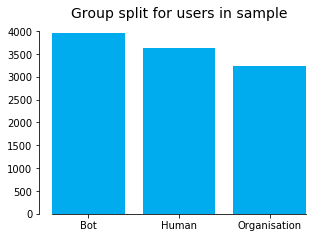

In [54]:
# plot to show the split of users
fig, ax = plt.subplots(figsize=(5,3.5))
plt.bar(x=user_split.index,height=user_split,color='#00acee')
plt.title('Group split for users in sample',fontsize=14)

# sort the styling
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.set_xticklabels(['Bot','Human','Organisation'])

# we could show this as say 50 people, and color code the dots for each proportion - if i can be bothered.

**Still undecided on second page - do we want to compare the datasets, or be able to filter?**

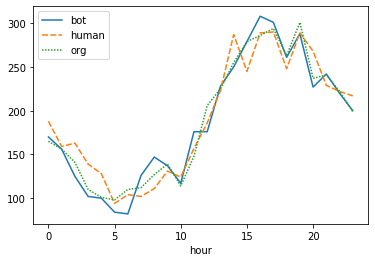

In [55]:
# hourly tweet activity 
df['date'] = pd.to_datetime(df.date, format='%d/%m/%Y %H:%M')
df['hour'] = df.date.apply(lambda x: x.hour)
hours = df.pivot_table(index='hour',values='id', columns='tag',aggfunc='count',margins = False)

sns.lineplot(data=hours)

In [56]:
# average replies, retweets, followers and account age
replies = df.groupby('tag')['replies'].mean()
retweets = df.groupby('tag')['retweets'].mean()
#age = df.groupby('tag')['age'].mean()
#followers = df.groupby('tag')['follower_count'].mean()

age = [1,2,3]
followers = [4,5,6]

table_2 = pd.DataFrame({'replies':replies,
                        'retweets':retweets, 
                        'age':age,
                        'followers':followers}).reset_index()
table_2

,tag,replies,retweets,age,followers
0,bot,0.776100,3.385606,1,4
1,human,0.721315,3.126715,2,5
2,org,0.711195,2.333849,3,6


**Third page gets into content analysis - this is where we filter by group**

In [57]:
# most common key words for each group
table_3 = pd.DataFrame(columns=['bot','human','org'])

for i in tags:
    sliced = df[df['tag'] == i]
    words_only = sliced['tokens']
    tokens = []
    for sublist in words_only:
        for item in sublist:
            tokens.append(item)


    freq = pd.DataFrame({'tokens':tokens,'count':1})
    word_frequency = freq.groupby(['tokens']).count()
    word_frequency = word_frequency.sort_values('count',ascending=False)
    word_frequency_50 = pd.DataFrame(word_frequency.head(5))
    l = list(word_frequency_50.index)
    table_3[i] = l
table_3

,bot,human,org
0,homelessness,homelessness,homelessness
1,people,people,people
2,amp,amp,eeriencing
3,nt,eeriencing,amp
4,eeriencing,nt,nt


In [58]:
# most common hashtag -  to compare with hashtags
table_4 = pd.DataFrame(columns=['bot','human','org'])

for i in tags:
    sliced = df[df['tag'] == i]
    sliced.dropna(subset = ["hashtags_"], inplace=True)
    words_only = sliced['hashtags_']
    tokens = []
    for sublist in words_only:
        for item in sublist:
            tokens.append(item)


    freq = pd.DataFrame({'tokens':tokens,'count':1})
    word_frequency = freq.groupby(['tokens']).count()
    word_frequency = word_frequency.sort_values('count',ascending=False)
    word_frequency_50 = pd.DataFrame(word_frequency.head(5))
    l = list(word_frequency_50.index)
    table_4[i] = l
table_4

/Users/jackpawson/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,bot,human,org
0,homelessness,homelessness,homelessness
1,covid19,covid19,covid19
2,coronavirus,coronavirus,coronavirus
3,homeless,homeless,homeless
4,axeals,axeals,poverty


In [59]:
# most popular users
for i in tags:
    print(i+"s")
    sliced = df[df['tag'] == i]
    group = sliced.groupby('username').sum()
    group = group.nlargest(5,'retweets')
    group = group.iloc[:,:3]
    print(group,"\n")

bots
                replies  retweets  favorites
username                                    
JulianCastro      519.0    4062.0    11940.0
ewarren           300.0    1268.0     5514.0
RevDrBarber        24.0     444.0      913.0
MikeGarcia2020    100.0     399.0      880.0
thrasherxy         19.0     358.0      698.0 

humans
                replies  retweets  favorites
username                                    
SenSanders        350.0    2076.0     7580.0
blunted_james      39.0     945.0     2919.0
TomLondon6         13.0     530.0      681.0
AndyPeacock999     21.0     528.0     1579.0
mitchellvii        88.0     364.0      980.0 

orgs
                 replies  retweets  favorites
username                                     
BSidesNarrative     33.0     555.0     2852.0
Rockprincess818     26.0     426.0     1846.0
jephjacques          5.0     318.0     1110.0
codeofvets          88.0     305.0      610.0
TheManUtdWay        13.0     258.0     2759.0 



In [60]:
# basic sentiment analysis (pos,neg,neutral)
res = []
for i in df['text']:
    j = p.clean(i)
    testimonial = TextBlob(j)
    res.append(testimonial.sentiment.polarity)
df['sent'] = res

Text(0.5, 1.0, 'Sentiment density')

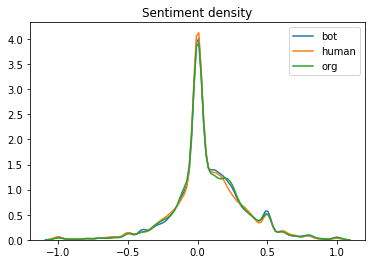

In [61]:
# plotting density
for i in tags:
    sliced = df[df['tag']==i]
    sns.kdeplot(sliced.sent)
plt.legend(tags)
plt.title('Sentiment density')

sentiment
negative    3382
neutral     3286
positive    6908
Name: id, dtype: int64


[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

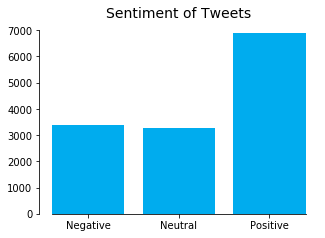

In [62]:
# recode for positive neutral and negative
df['sentiment'] = pd.cut(df['sent'], bins=[-1, -0.0001,0.0001, 1], labels=['negative', 'neutral', 'positive'])

# group by sentiment
sentiment = df.groupby('sentiment')['id'].count()
print(sentiment)

# plot to show the split of users
sentiment = df.groupby('sentiment')['id'].count()
fig, ax = plt.subplots(figsize=(5,3.5))
plt.bar(x=sentiment.index,height=sentiment,color='#00acee')
plt.title('Sentiment of Tweets',fontsize=14)

# sort the styling
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.set_xticklabels(['Negative','Neutral','Positive'])

**Fourth page is domain specific textual analysis**

In [63]:
hashtags = df.iloc[:,[1,10]]

**Final page is hashtag interaction network themed by sentiment**

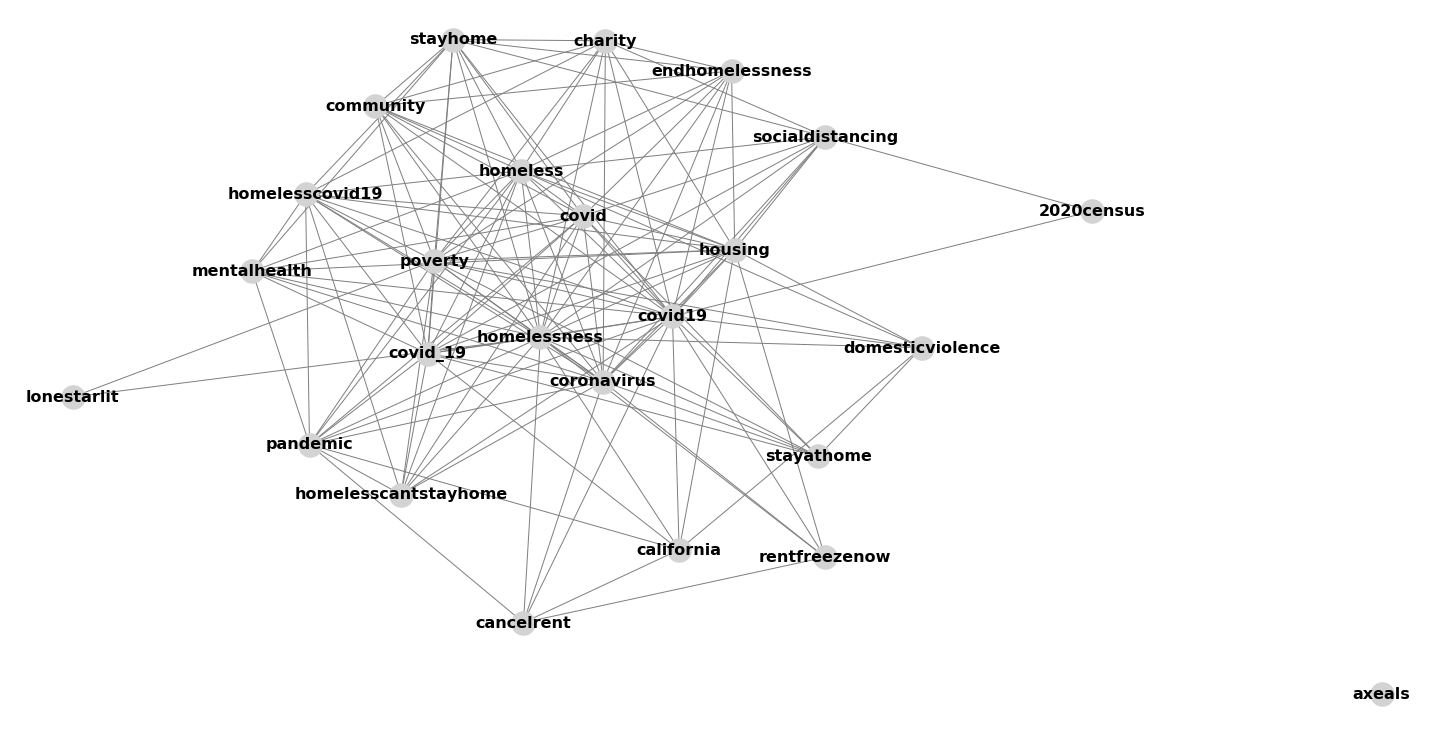

In [64]:
# top25 hashtag network
#df2 = df[df['tag'] == 'human']
hashtags = pd.DataFrame(df.iloc[:,[1,10]])
hashtags.dropna(subset = ["hashtags_"], inplace=True)
user_to_hashtags=dict(hashtags.values) 

d = user_to_hashtags 
inverse = dict() 
for key in d: 
    # Go through the list that is saved in the dict:
    for item in d[key]:
        # Check if in the inverted dict the key exists
        if item not in inverse: 
                # If not create a new list
            inverse[item] = [key] 
        else: 
            inverse[item].append(key) 
e = inverse

sorted_items = sorted(e.items(), key = lambda item : len(item[1]))
hashtag_to_users = dict(sorted_items[-25:])

test = pd.DataFrame(list(hashtag_to_users.items()),columns = ['hashtag','users']) 

user_to_hashtags=dict(test[['hashtag','users']].values) 
#a more convenient data structure: a dictionary with users as keys and the list of hashtags they use as values.

B = nx.Graph() #create an empty graph

for user in user_to_hashtags: #loop over all the users
    for hashtag in user_to_hashtags[user]: #for each user loop over the hashtags they use
        B.add_edge(user,hashtag) #add the edge User<->hashtag

actual_users_with_hashtags = [x for x in list(set(test.hashtag)) if x in B.nodes()] 
G = nx.bipartite.weighted_projected_graph(B,nodes =actual_users_with_hashtags) # creates the graph object

plt.figure(figsize=(20,10))
nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=600, \
    node_color='lightgrey', edge_color = 'grey',linewidths=0.01, font_size=16, \
    font_weight='bold', with_labels=True)
plt.show()

In [65]:
import igraph as igraph

In [66]:
relations = user_to_hashtags
g = igraph.Graph()
g.add_vertices(list(set(list(relations.keys()) + list([a for v in relations.values() for a in v]))))
g.add_edges([(v, a) for v in relations.keys() for a in relations[v]])

In [67]:
# need to sort out cairo compiler
#layout = g.layout("kk")
#igraph.plot(g, layout = layout)

In [68]:
# top25 hashtag network themed by sentiment
# if tweet contains hashtag what was the sentiment of it?
hashtags_list = test.hashtag.to_list()
hashtags_sentiment = pd.DataFrame(df.iloc[:,[1,10,-2]])
hashtags_sentiment.dropna(subset = ["hashtags_"], inplace=True)
hashtags_sentiment['hashtags_'] = hashtags_sentiment['hashtags_'].apply(lambda x: ','.join(map(str, x)))

In [69]:
hashtags_sentiment.head()

,username,hashtags_,sent
7,leggsplace,"homelessness,addiction,author",0.75
14,philanthrobe,"risingmajority,feministeconomy",0.00
20,adarayaffa,"homelessness,covid19pandemic,localgov",0.30
21,LdnHomeless,"ldnont,homelessness,housing,covid19",0.00
22,GeorginaMarce,risingmajority,0.00


In [70]:
mean_sen = []

for i in hashtags_list:
    s = hashtags_sentiment['hashtags_'].str.contains(i)
    sen = hashtags_sentiment['sent'][s.values].mean()
    mean_sen.append(sen)
test['mean_sentiment'] = mean_sen

In [71]:
test['iqr'] = pd.qcut(test.mean_sentiment,4,labels=[1,2,3,4])
test

,hashtag,users,mean_sentiment,iqr
0,california,"[KAS_SB, Phoenixtl, mark_vallen, ComDevsUnion,...",-0.016643,1
1,domesticviolence,"[ChandlerAZProud, anotherwindle, SpeyeJoe, res...",0.146783,4
2,charity,"[WisecarverPR, chrisoldcorn, VFoudation, sta58...",0.263332,4
3,community,"[kcahtweets, LightofLife, EVMSedu, hildselfhel...",0.204842,4
4,lonestarlit,"[GailTrishGentry, mpax1, rsguthrie, fromjessto...",0.052632,2
5,cancelrent,"[Phoenixtl, fierman_gallery, ShaneMcKill, mali...",0.063770,2
6,socialdistancing,"[PovertyandArts, SG_Hardin, ultratapww, thepla...",-0.000297,1
7,endhomelessness,"[jon_sparkes, FindYEG, hildselfhelp, VFoudatio...",0.091873,3
8,homelesscantstayhome,"[rm199992, GriffKohout, elkjrras, AllenRheinha...",-0.078273,1
9,mentalhealth,"[RainbowCentre01, mOppenheimORG, ExpertLink201...",0.047629,1


In [72]:
color_map = []
for node in test.iqr:
    if node == 1:
        color_map.append('skyblue')
    elif node == 2:
        color_map.append('dodgerblue')
    elif node == 2:
        color_map.append('royalblue')   
    else: 
        color_map.append('blue') 
color_map

['skyblue',
 'blue',
 'blue',
 'blue',
 'dodgerblue',
 'dodgerblue',
 'skyblue',
 'blue',
 'skyblue',
 'skyblue',
 'dodgerblue',
 'blue',
 'skyblue',
 'skyblue',
 'skyblue',
 'dodgerblue',
 'blue',
 'blue',
 'dodgerblue',
 'blue',
 'blue',
 'blue',
 'dodgerblue',
 'blue',
 'blue']

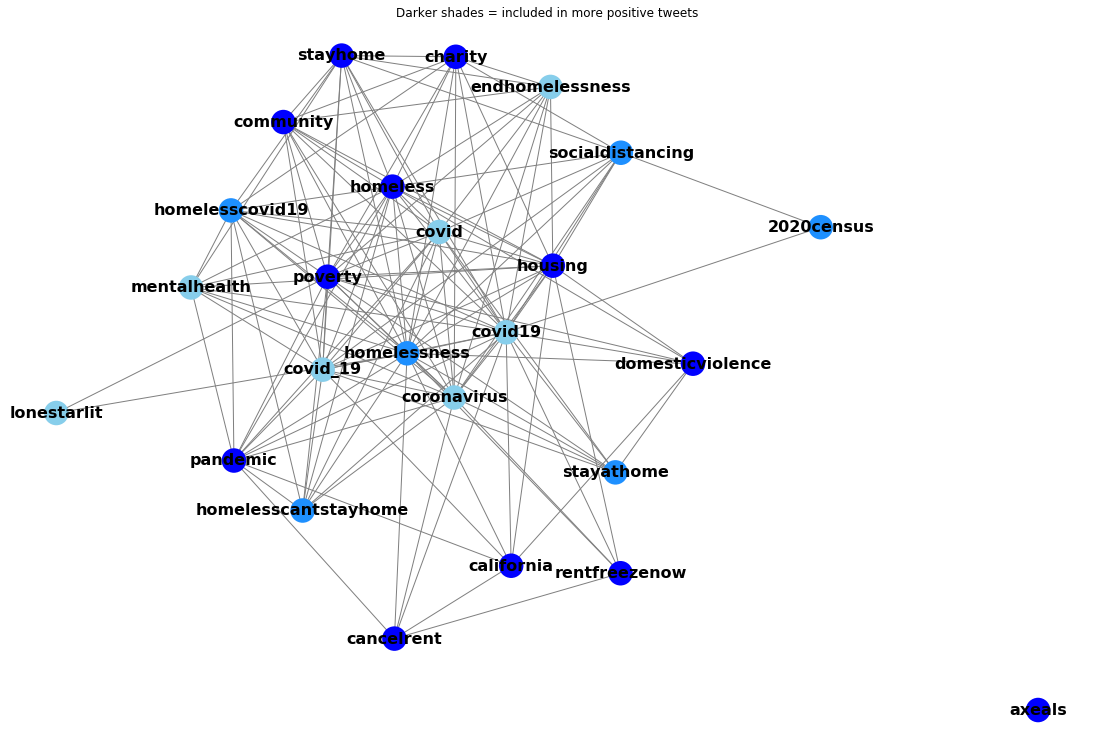

In [73]:
plt.figure(figsize=(15,10))
nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G), node_size=600, \
    node_color = color_map, edge_color = 'grey',linewidths=0.01, font_size=16, \
    font_weight='bold', with_labels=True)
plt.title("Darker shades = included in more positive tweets")
plt.show()

In [74]:
# topic analysis
df.text[2],df.text_clean[2]

('homelessness in america is being force through volatile behavior. but wait.. i thought she was being abused?',
 'homelessness america force volatile behavior wait thought abused')

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=100, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['text_clean']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
tf.shape # --> (200000, 2296)

<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \w
<ipython-input-75-18b5b572b758>:4: DeprecationWarning: invalid escape sequence \w
  vectorizer = CountVectorizer(max_df=0.9, min_df=100, token_pattern='\w+|\$[\d\.]+|\S+')


(13624, 415)

In [76]:
from sklearn.decomposition import LatentDirichletAllocation
number_of_topics = 5
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=45) # random state for reproducibility
# Fit data to model
model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=45, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [77]:
topicnames = ["Topic" + str(i) for i in range(model.n_components)]

In [78]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,000,22,able,abuse,access,account,across,act,action,actually,...,youth,yrs,‚ä¶,‚äôll,‚äôm,‚äôre,‚äôs,‚äôt,‚äôve,‚äù
Topic0,33.222922,0.200018,21.676773,0.201848,72.968521,0.200529,87.568736,73.083860,58.340032,0.571822,...,221.442456,0.200430,54.532075,0.201364,0.201035,0.201832,150.003158,0.201096,0.201411,41.583849
Topic1,62.746842,0.200222,52.551981,0.202426,41.229118,0.200732,16.516333,39.272724,44.032713,0.230194,...,0.954157,0.200685,57.812145,0.201083,0.201323,0.202587,0.202468,0.201489,0.200923,142.813671
Topic2,31.295603,0.200081,57.791957,211.373360,47.351861,0.201357,37.140250,10.236453,0.202265,25.716308,...,0.201970,0.201279,0.203267,0.200578,0.200891,0.200749,0.208646,0.201354,0.200954,39.484450
Topic3,2.533802,0.200078,34.868266,24.021558,0.245579,0.201415,10.572874,0.204877,0.202824,136.280589,...,0.201161,0.201102,2.251759,133.196209,253.196277,315.194184,1228.384922,1159.195204,186.196199,241.916607
Topic4,0.200830,123.199601,4.111024,0.200808,0.204921,127.195966,0.201808,0.202085,48.222167,0.201087,...,0.200256,130.196504,0.200755,0.200766,0.200474,0.200648,0.200805,0.200857,0.200513,0.201424


In [79]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=model, n_words=15)        


In [80]:
topic_keywords

[array(['homelessness', 'eeriencing', 'people', 'housing', 'homeless',
        'support', 'covid19', 'crisis', 'coronavirus', 'help', 'need',
        'city', 'services', 'emergency', 'shelter'], dtype='<U12'),
 array(['homelessness', 'people', 'help', 'home', 'us', 'eeriencing',
        'need', 'risk', 'please', 'homeless', 'stay', 'facing', 'many',
        'one', 'families'], dtype='<U12'),
 array(['homelessness', 'nt', 'poverty', 'people', 'health', 'would',
        'amp', 'years', 'social', 'etc', 'unemployment', 'housing', 'ca',
        'crisis', 'country'], dtype='<U12'),
 array(['homelessness', '‚äôs', '‚äôt', 'people', 'like', 'it', 'know',
        'i', 'don', 'one', 'get', '‚äôre', 'problem', 'homeless', 'still'],
       dtype='<U12'),
 array(['amp', 'als', 'may', 'homelessness', 'rent', 'getting', 'pay',
        'american', 'americans', 'due', 'dying', 'rest', 'america', 'lack',
        'shut'], dtype='<U12')]

In [81]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,homelessness,eeriencing,people,housing,homeless,support,covid19,crisis,coronavirus,help,need,city,services,emergency,shelter
Topic 1,homelessness,people,help,home,us,eeriencing,need,risk,please,homeless,stay,facing,many,one,families
Topic 2,homelessness,nt,poverty,people,health,would,amp,years,social,etc,unemployment,housing,ca,crisis,country
Topic 3,homelessness,‚äôs,‚äôt,people,like,it,know,i,don,one,get,‚äôre,problem,homeless,still
Topic 4,amp,als,may,homelessness,rent,getting,pay,american,americans,due,dying,rest,america,lack,shut


In [82]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, tf, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  27.582803
0       51.163364 -159.968018       2        1  23.184865
3      -73.144554   21.523815       3        1  22.272842
1      -66.410133 -110.606438       4        1  17.859180
4       54.417324   12.443444       5        1   9.100309, topic_info=           Term         Freq        Total Category  logprob  loglift
25          amp  1960.000000  1960.000000  Default  30.0000  30.0000
412        ‚äôt  1126.000000  1126.000000  Default  29.0000  29.0000
411        ‚äôs  1339.000000  1339.000000  Default  28.0000  28.0000
100  eeriencing  1683.000000  1683.000000  Default  27.0000  27.0000
17          als   552.000000   552.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
352       thank   167.164687   406.209132   Topic5  -4.2011   1.5090
43           ca   168.584146   461.430847   Topic5  -4.1926   1.3900
301         say   162.759094   382.347303   Topic5  -4.2278   1.5428
247          nt   189.388718  1598.948717   Topic5  -4.0762   0.2636
341     support   164.550725   899.408656   Topic5  -4.2168   0.6983

[276 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         5  0.995678        22
3         1  0.897774     abuse
3         3  0.099753     abuse
5         5  0.998028   account
9         1  0.157701  actually
...     ...       ...       ...
413       3  0.996248     ‚äôve
414       1  0.084767       ‚äù
414       2  0.086940       ‚äù
414       3  0.510773       ‚äù
414       4  0.317331       ‚äù

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2, 5])